In [1]:
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras.layers import Conv1D, Flatten,MaxPooling1D
import wandb
from wandb.keras import WandbCallback
import numpy as np
from keras.preprocessing import text
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [2]:
df = pd.read_csv("F://NLP_ProjectII/merged.csv", encoding='utf-16')
df.head()

,Label,Text
0,Chinh tri Xa hoi,thành_lập dự_án policy phòng_chống hivaids ở v...
1,Chinh tri Xa hoi,hơn 16 000 khách đến vịnh nha trang theo trực_...
2,Chinh tri Xa hoi,tphcm khai_trương dịch_vụ lặn biển săn cá_mập ...
3,Chinh tri Xa hoi,du_lịch vn sẽ có tư_vấn nước_ngoài ông phạm từ...
4,Chinh tri Xa hoi,quy_chế tuyển_sinh 2006 không làm_tròn điểm từ...


In [3]:
label_counts = df['Label'].value_counts()
print(label_counts)

Label
Chinh tri Xa hoi    12786
The thao            11965
The gioi             9614
Van hoa              9330
Suc khoe             8801
Kinh doanh           7828
Phap luat            7656
Vi tinh              7041
Doi song             5195
Khoa hoc             3916
Name: count, dtype: int64


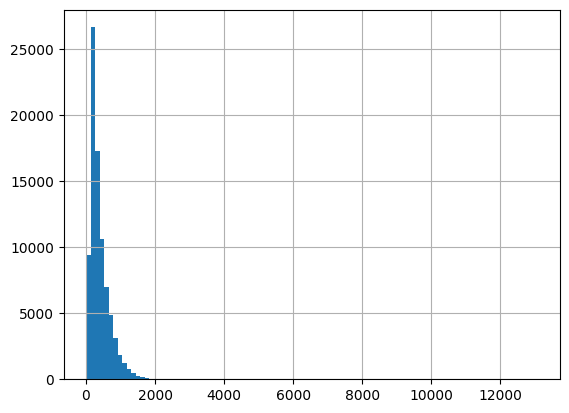

In [4]:
seq_len =[len(i.split()) for i in df.Text]
pd.Series(seq_len).hist(bins = 100)
plt.show()

In [5]:
print([max(seq_len), min (seq_len)])

[13065, 5]


In [6]:
wandb.init()
config = wandb.config

config.vocab_size = 50000
config.maxlen = 500
config.batch_size = 32
config.embedding_dims = 50
config.filters = 10
config.kernel_size = 3
config.hidden_dims = 10
config.epochs = 10


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttkhang202. Use `wandb login --relogin` to force relogin


In [7]:
tokenizer = Tokenizer(num_words= config.vocab_size)
tokenizer.fit_on_texts(df['Text'].values)

le = len(tokenizer.word_index) + 1
print(le)
sequences = tokenizer.texts_to_sequences(df['Text'].values)                                        
X_DeepLearning = pad_sequences(sequences, maxlen= config.maxlen)

136920


In [8]:
df.loc[df['Label'] == 'Chinh tri Xa hoi', 'Label'] = 0
df.loc[df['Label'] == 'The thao', 'Label'] = 1
df.loc[df['Label'] == 'The gioi', 'Label'] = 2
df.loc[df['Label'] == 'Van hoa', 'Label'] = 3
df.loc[df['Label'] == 'Suc khoe', 'Label'] = 4
df.loc[df['Label'] == 'Kinh doanh', 'Label'] = 5
df.loc[df['Label'] == 'Phap luat', 'Label'] = 6
df.loc[df['Label'] == 'Vi tinh', 'Label'] = 7
df.loc[df['Label'] == 'Doi song', 'Label'] = 8
df.loc[df['Label'] == 'Khoa hoc', 'Label'] = 9

labels = to_categorical(df['Label'], num_classes=10)
X_train, X_test, y_train, y_test = train_test_split(X_DeepLearning, labels, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1,random_state=42)
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))


((53002, 500), (53002, 10), (25240, 500), (25240, 10))


In [9]:
model = Sequential()
model.add(Embedding(config.vocab_size,
                    config.embedding_dims,
                    input_length=config.maxlen))
model.add(Conv1D(config.filters,
                 config.kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(LSTM(config.hidden_dims, activation="sigmoid"))
model.add(Dense(10, activation='sigmoid'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history1 = model.fit(X_train, y_train,
          batch_size=config.batch_size,
          epochs=config.epochs,
          validation_data=(X_valid, y_valid), callbacks=[WandbCallback()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           2500000   
                                                                 
 conv1d (Conv1D)             (None, 498, 10)           1510      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 10)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 10)                840       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
Total params: 2,502,460
Trainable params: 2,502,460
Non-trainable params: 0
______________________________________________

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
1657/1657 [==============================] - ETA: 0s - loss: 1.7804 - accuracy: 0.4006

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 154s 92ms/step - loss: 1.7804 - accuracy: 0.4006 - val_loss: 1.3022 - val_accuracy: 0.6197
Epoch 2/10
1657/1657 [==============================] - ETA: 0s - loss: 1.0187 - accuracy: 0.7187

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 157s 94ms/step - loss: 1.0187 - accuracy: 0.7187 - val_loss: 0.8707 - val_accuracy: 0.7750
Epoch 3/10
1657/1657 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.8315

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 154s 93ms/step - loss: 0.6583 - accuracy: 0.8315 - val_loss: 0.6561 - val_accuracy: 0.8166
Epoch 4/10
1657/1657 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.8743

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 155s 93ms/step - loss: 0.4666 - accuracy: 0.8743 - val_loss: 0.5792 - val_accuracy: 0.8362
Epoch 5/10
1657/1657 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.9104

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 149s 90ms/step - loss: 0.3503 - accuracy: 0.9104 - val_loss: 0.5687 - val_accuracy: 0.8470
Epoch 6/10
1657/1657 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9362

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 124s 75ms/step - loss: 0.2711 - accuracy: 0.9362 - val_loss: 0.5613 - val_accuracy: 0.8458
Epoch 7/10
1657/1657 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9515

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 125s 75ms/step - loss: 0.2129 - accuracy: 0.9515 - val_loss: 0.5585 - val_accuracy: 0.8521
Epoch 8/10
1657/1657 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9605

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_110014-x8q1kfhc\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 126s 76ms/step - loss: 0.1733 - accuracy: 0.9605 - val_loss: 0.5571 - val_accuracy: 0.8596
Epoch 9/10
1657/1657 [==============================] - 122s 74ms/step - loss: 0.1385 - accuracy: 0.9691 - val_loss: 0.5967 - val_accuracy: 0.8516
Epoch 10/10
1657/1657 [==============================] - 123s 74ms/step - loss: 0.1119 - accuracy: 0.9757 - val_loss: 0.5919 - val_accuracy: 0.8584


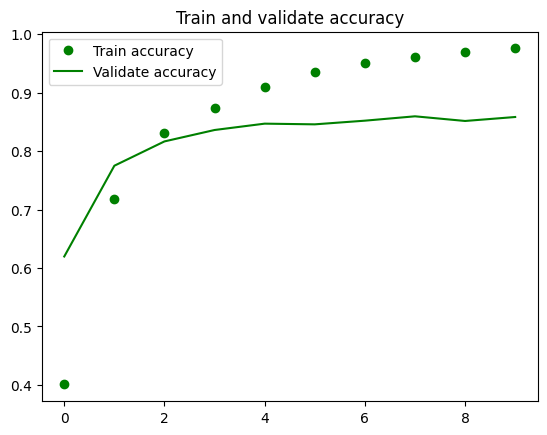

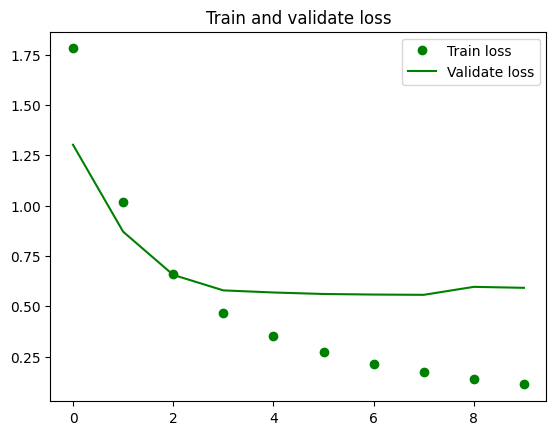

In [13]:
acc = history1.history['accuracy']                          
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show() 

LSTM thêm dropout

In [9]:
config.epochs = 30

In [11]:
model2 = Sequential()
model2.add(Embedding(config.vocab_size,
                    config.embedding_dims,
                    input_length=config.maxlen))
model2.add(SpatialDropout1D(0.7))
model2.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model2.add(Dense(10, activation='softmax'))
model2.summary()
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(X_train, y_train,
          batch_size=config.batch_size,
          epochs=config.epochs,
          validation_data=(X_valid, y_valid), callbacks=[WandbCallback()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           2500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 50)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 2,530,090
Trainable params: 2,530,090
Non-trainable params: 0
_________________________________________________________________


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
1657/1657 [==============================] - ETA: 0s - loss: 1.9139 - accuracy: 0.2888

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_173204-amxdg22q\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_173204-amxdg22q\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_173204-amxdg22q\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 549s 330ms/step - loss: 1.9139 - accuracy: 0.2888 - val_loss: 1.5373 - val_accuracy: 0.3784
Epoch 2/30
1657/1657 [==============================] - ETA: 0s - loss: 1.5408 - accuracy: 0.4418

INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_173204-amxdg22q\files\model-best\assets


INFO:tensorflow:Assets written to: f:\NLP_ProjectII\wandb\run-20230721_173204-amxdg22q\files\model-best\assets
wandb: Adding directory to artifact (f:\NLP_ProjectII\wandb\run-20230721_173204-amxdg22q\files\model-best)... Done. 0.1s


1657/1657 [==============================] - 559s 337ms/step - loss: 1.5408 - accuracy: 0.4418 - val_loss: 1.3594 - val_accuracy: 0.5081
Epoch 3/30
1657/1657 [==============================] - 573s 346ms/step - loss: 1.3893 - accuracy: 0.5203 - val_loss: 1.7251 - val_accuracy: 0.4645
Epoch 4/30
 420/1657 [======>.......................] - ETA: 7:20 - loss: 1.3050 - accuracy: 0.5613

In [ ]:
acc = history2.history['accuracy']                          
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show() 